In [51]:
import os
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, r2_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, accuracy_score, classification_report, silhouette_score
from sklearn.model_selection import learning_curve, train_test_split
from scipy.stats import normaltest
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, AgglomerativeClustering
from pandas.plotting import parallel_coordinates
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import pandas_ta as ta
import xgboost as xgb
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
from fredapi import Fred
import kagglehub
# %matplotlib inline

# Problem Statement 

Use an unsupervised K-Means clustering approach to detect likely credit-card fraud transactions in the Kaggle creditcard.csv dataset (transactions labeled in column Class, where 1 = fraud, 0 = normal). Because fraud is extremely rare, treat this as an anomaly detection exercise: K-Means will be used to find clusters and anomaly scores; then we will evaluate against the true labels to measure detection quality.

In [183]:
# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

fraud_fraction = 1
cluster_num = 6

In [222]:
from pathlib import Path
def data_import(location):
    if os.path.exists(location):
        location = Path(location)
        filename = Path("creditcard.csv")
        location = Path.joinpath(location, filename)
        df = pd.read_csv(location)
        return df
    else:
        print("File not found. Please check the location")
        
def preprocessing(df):
    # Drop rows with missing values (if any) and isolate features
    df = df.copy()
    if 'Class' not in df.columns:
        raise ValueError("Dataset must contain 'Class' column for evaluation.")
    # Scale Amount separately
    if 'Amount' in df.columns:
        df['Amount_log'] = np.log1p(df["Amount"])#MinMaxScaler().fit_transform(df[['Amount']])
    feature_cols = [c for c in df.columns if (c.startswith('V'))] + ["Amount_log"]
    X = df[feature_cols].values
    y = df['Class'].values
    X_scaled = StandardScaler().fit_transform(X)
    return df, X_scaled, y, feature_cols#, df[feature_cols]
    
    
    
def Kmeans_model(X, method,num_cluster=cluster_num, random_state=42, fraud_fraction=fraud_fraction):
    if method=="KMeans":
        kmeans = KMeans(n_clusters=num_cluster, random_state=random_state)
    elif method=="KMeans++":
        kmeans = KMeans(n_clusters=num_cluster, random_state=random_state, init="k-means++", n_init=10)
    else:
        print("Please enter a valid method")
    
    kmeans.fit(X)
    cluster_centers = kmeans.cluster_centers_
    distances = np.linalg.norm(X - cluster_centers[kmeans.labels_], axis=1)
    class_threshold = np.percentile(distances, 100-fraud_fraction)
    y_pred = (distances>=class_threshold).astype(int)
    
    return {"centroids": cluster_centers, "distances": distances, 
            "threshold": class_threshold, "y_pred": y_pred, "confusion_matrix": confusion_matrix(y, y_pred),
           "labels": kmeans.labels_}
    
    
def evaluation_metrics(y,y_pred, score=None):
    print("Confusion matrix:\n", confusion_matrix(y, y_pred))
    print("\nClassification report:")
    print(classification_report(y, y_pred, digits=4))
    if score is not None:
        try:
            roc = roc_auc_score(y, score)
            print(f"ROC-AUC (scores): {roc:.4f}")
            prec, rec, _ = precision_recall_curve(y, scores)
            pr_auc = auc(rec, prec)  # PR AUC using curve values
            print(f"PR-AUC (scores): {pr_auc:.4f}")
        except Exception as e:
            print("Could not compute AUC:", e)
            

    
    
def result_plots(X, method, cm=confusion_matrix(y,y_pred), df=df, num_cluster=cluster_num, random_state=42, fraud_fraction=fraud_fraction):
    if method=="KMeans":
        kmeans = KMeans(n_clusters=num_cluster, random_state=random_state)
    elif method=="KMeans++":
        kmeans = KMeans(n_clusters=num_cluster, random_state=random_state, init="k-means++", n_init=10)
    else:
        print("Please enter a valid method")
    kmeans.fit(X)
    
#     #correlation matrix of the features
#     sns.heatmap(X.corr(), annot=True, cmap="coolwarm")
#     plt.title("Correlation Matrix")
#     plt.show()
    
    #elbow plot first
    wcss = []
    for k in range(1, 20):
        wcss.append(kmeans.inertia_)
    plt.plot(range(1,20), wcss)
    plt.xlabel("Number of clusters (K)")
    plt.ylabel("WCSS (Inertia)")
    plt.title("Elbow Method for Optimal K")
    plt.grid(True)
    plt.show()
    
    #confusion matrix
#     cm = confusion_matrix(labels, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Fraud","Fraud"])
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix - KMeans")
    plt.show()
    
    
    #parallel coordiantes plot
    samples = df.sample(1000, random_state=random_state)
    parallel_coordinates(samples[["Class"] + [f"V{i}" for i in range(1,8)]],"Class" , colormap="viridis") #samples[["Cluster"] + [f"V{i}" for i in range(1,6)]], "Cluster"
    plt.title("Parallel Coordinates Plot (Subset of Features)")
    plt.show()

    #precision recall curve
    
    
    
#     histogram, clusters, parallel coordinates plot


{'centroids': array([[-6.26422988e-03,  1.92505650e-01,  2.70642457e-01,
         8.91574742e-01,  1.47322592e-01,  2.76688404e-01,
         2.58915799e-02,  7.40104990e-02, -1.64863782e-01,
         1.40404965e-01, -2.39898817e-01,  2.91736736e-01,
        -1.80332516e-01,  1.35104574e-01, -7.34366718e-02,
        -1.95518909e-01, -2.43753400e-01,  6.93467946e-02,
        -7.77228492e-02, -9.77835935e-02,  6.35209653e-02,
         1.90568407e-01, -6.04088704e-02,  1.80358175e-02,
         2.38986766e-01, -6.39237602e-01, -1.01067129e-02,
        -1.90228294e-02,  9.35536435e-02],
       [ 2.67167607e-01, -6.60906433e-01,  4.17309251e-02,
        -1.00664919e+00, -5.07680709e-01, -1.37554703e-02,
        -5.17697726e-01, -1.60148783e-02, -9.85707683e-01,
         7.19242448e-01, -1.74761707e-02, -5.36634710e-01,
         5.51707989e-02, -3.77558113e-01, -2.35923630e-01,
         5.89386477e-01,  3.73858966e-01, -6.53922037e-01,
         3.81504295e-01,  5.32888945e-02,  1.42258220e-01,

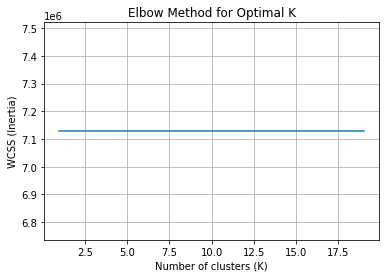

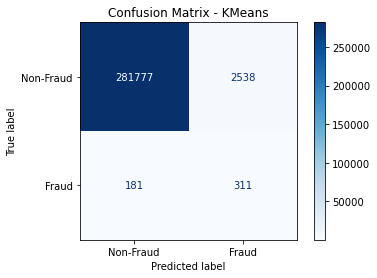

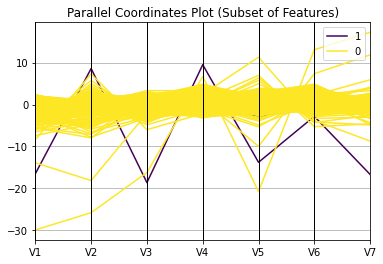

In [223]:
#main function

def main():
    df = data_import(path)
    
#     print(df.describe())
    
    df, X_scaled, y, feature_cols = preprocessing(df)
    
    pred_dict = Kmeans_model(X_scaled, method="KMeans")
    y_pred = pred_dict["y_pred"]
    
    print(pred_dict)
    
    evaluation_metrics(y, y_pred, score=None)
    
    result_plots(X_scaled, method="KMeans", cm=confusion_matrix(y,y_pred), df=df)
    
    
    
    
if __name__ == "__main__":
    main()    

In [185]:
cluster_centers, distances, class_threshold, y_pred = Kmeans_model(X_scaled, "KMeans")
evaluation_metrics(y,y_pred)

Confusion matrix:
 [[281777   2538]
 [   181    311]]

Classification report:
              precision    recall  f1-score   support

           0     0.9994    0.9911    0.9952    284315
           1     0.1092    0.6321    0.1862       492

    accuracy                         0.9905    284807
   macro avg     0.5543    0.8116    0.5907    284807
weighted avg     0.9978    0.9905    0.9938    284807



In [186]:
indices_y, indices_y_pred = np.array(np.where(y==1)), np.array(np.where(y_pred==1))
plt.hist(abs(indices_y - indices_y_pred))

ValueError: operands could not be broadcast together with shapes (1,492) (1,2849) 

In [187]:
i, fraud_count, unfruad_count=0,0,0
while i<len(y):
    if y[i]==1:
        if y_pred[i]==1:
            fraud_count=fraud_count+1
        else:
            unfruad_count = unfruad_count+1
    else:
        pass
    i=i+1
        
accurac = fraud_count / np.count_nonzero(y)
print(fraud_count, unfruad_count, accurac)

311 181 0.6321138211382114


<AxesSubplot:>

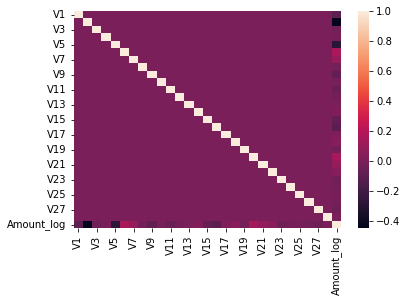

In [199]:
df = data_import(path)
df, X_scaled, y, feature_cols = preprocessing(df)


In [88]:
df = data_import(path)
df, X_scaled, y, feature_cols = preprocessing(df)

In [65]:
df.describe()
# df["Class"].hist(log="True")

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Amount_scaled
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727,0.003439
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527,0.009736
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000,0.000218
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000,0.000856
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000,0.003004
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000,1.000000


In [ ]:
#Use k means to group the similar datasets
#detect the outliers
#features are names as V1, V2, etc.